## Download model and data

In [1]:
# download the file and save it to the specified directory
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/test/cat_dog.jpg -P test_img

--2024-10-31 13:53:42--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/test/cat_dog.jpg
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 817995 (799K) [image/jpeg]
Saving to: 'test_img/cat_dog.jpg.2'

cat_dog.jpg.2       100%[===================>] 798.82K  1.62MB/s    in 0.5s    

2024-10-31 13:53:42 (1.62 MB/s) - 'test_img/cat_dog.jpg.2' saved [817995/817995]



In [2]:
import torch
from torchvision import transforms # data preprocess
from torchvision.models import resnet50
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model= resnet50(pretrained=True).eval().to(device)
# define a conversion process of data preprocessing
test_transform= transforms.Compose([transforms.Resize(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Load model and process data

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
img_path= './test_img/cat_dog.jpg' # setting file path
img_animal= Image.open(img_path) # PIL type
input_img= test_transform(img_animal).unsqueeze(0).to(device) # process data

## Using Grad-CAM

### Define hook

In [5]:
class HookActsGrads:
    def __init__(self, model):
        self.model= model
        self.activations= None
        self.gradients= None
        self.register_hooks()

    def register_hooks(self):
        self.model.layer4[-1].register_forward_hook(self.save_activation)
        self.model.layer4[-1].register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations= output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients= grad_output[0]

### Forward and Backward

In [6]:
# forward
hook= HookActsGrads(model)
output= model(input_img)
# predicted_class= output.argmax(dim= 1)
# 232 边牧犬; 281 虎斑猫
predicted_class= torch.tensor([232]).to(device)
# backward
model.zero_grad()
output[0][predicted_class].backward()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [7]:
# pooling gradients
activations= hook.activations[0]
gradients= hook.gradients
pooled_gradients= torch.mean(gradients, dim= [0, 2, 3])

### Compute heatmap

In [8]:
# weighted heatmap
for i in range(len(pooled_gradients)):
    activations[i, :, :]*= pooled_gradients[i]
heatmap= activations.mean(dim= 0).detach().cpu().numpy()

In [9]:
# bi-linear heatmap
heatmap= np.maximum(heatmap, 0) # ReLU
heatmap= np.uint8(255* heatmap/ heatmap.max())
heatmap= Image.fromarray(heatmap).resize(img_animal.size, Image.BILINEAR)
# convert RGB mode
heatmap= np.array(heatmap)[:, :, np.newaxis]
heatmap= np.concatenate((heatmap, heatmap, heatmap), axis=2)
heatmap= Image.fromarray(heatmap)

### Draw bleeding picture

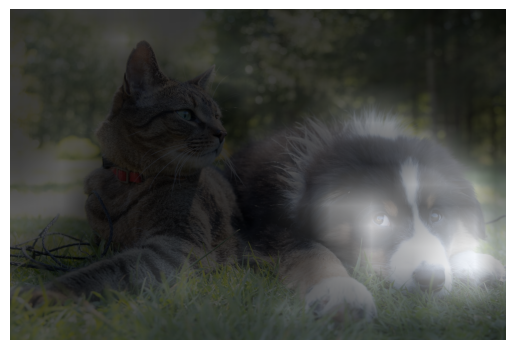

In [10]:
overlay= Image.blend(img_animal, heatmap, alpha= 0.8)
plt.imshow(overlay)
plt.axis('off')
plt.show()